# ALTEGRAD Kaggle challenge

# I) Imports

In [1]:
!nvidia-smi

Wed Jan 31 22:55:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:01:00.0 Off |                  Off |
| 56%   81C    P2             224W / 230W |  11777MiB / 24564MiB |     91%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Go back to root folder
%cd ..
%pwd

/users/eleves-b/2020/thomas.li/MVA/ALTEGRAD/kaggle_challenge


'/users/eleves-b/2020/thomas.li/MVA/ALTEGRAD/kaggle_challenge'

In [3]:
# Install packages
# !pip install wandb onnx -Uq

# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sns

sns.set_theme()

import pandas as pd
from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
from torch_geometric.data import DataLoader
from torch.utils.data import DataLoader as TorchDataLoader
from transformers import AutoTokenizer

# Imports from custom package
from original_src.dataloader import GraphTextDataset, GraphDataset, TextDataset

from original_src.Model import Model

# from original_src.Model2 import Model

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# WandB Login and Setup
import wandb

wandb.login()
PROJECT_NAME = "ALTEGRAD_kaggle"  # TODO

/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: qwertyr2. Use `wandb login --relogin` to force relogin


# Utils

In [4]:
from datetime import datetime
import yaml


def get_date_time_string():
    # Get current date and time
    now = datetime.now()

    # Extract year, month, day, hour, and minute
    month = now.month
    day = now.day
    hour = now.hour
    minute = now.minute

    # Format as a string of integers (yyyymmddHHMM)
    date_time_string = f"_{month:02d}{day:02d}{hour:02d}{minute:02d}"

    return date_time_string


import numpy as np
from sklearn.metrics import label_ranking_average_precision_score


def LRAP_accuracy(similarity_matrix):
    N, M = similarity_matrix.shape
    assert N == M
    y_true = np.eye(N, dtype=int)
    LRAP = label_ranking_average_precision_score(y_true, similarity_matrix)

    return LRAP


def load_yaml_config_as_dict(yaml_path):
    with open(yaml_path, "r") as file:
        config = yaml.safe_load(file)
        config.pop("_wandb")
        return config


def layer_normalize(input_tensor):
    mean = input_tensor.mean(dim=1, keepdim=True)
    std = torch.sqrt((input_tensor**2).sum(dim=1, keepdim=True))
    return (input_tensor - mean) / std

### default_config

In [5]:
# Default config as dictionary
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=10,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=True,
)


# Default config as class instance
class Config_Class:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            setattr(self, k, v)


config_instance = Config_Class(config)

#### Debugging

Vizulize text

In [11]:
from transformers import AutoTokenizer

# Load the AutoTokenizer with distilbert-base-uncased
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
scibert_tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Input sentences
sentences = [
    "Xanthurenate is a quinolinemonocarboxylate that is the conjugate base of xanthurenic acid, obtained by deprotonation of the carboxy group. It has a role as an animal metabolite. It is a conjugate base of a xanthurenic acid.",
    "5,10-(methanylylidene)tetrahydromethanopterin(2-) is a doubly-charged organophosphate oxoanion arising from deprotonation of the carboxy and phosphate OH groups of the cationic species 5,10-(methanylylidene)tetrahydromethanopterin; major species at pH 7.3. It is an organophosphate oxoanion and a dicarboxylic acid dianion. It is a conjugate base of a 5,10-(methanylylidene)tetrahydromethanopterin.",
    "Alpha-L-Fucp-(1->4)-[beta-D-Galp3S-(1->3)]-beta-D-GlcpNAc is a branched amino trisaccharide consisting of N-acetylglucosamine having a fucosyl residue attached at the 4-position via an alpha-linkage and a 3-sulfated galactosyl residue attached at the 3-position via a beta-linkage. It has a role as an epitope. It is an amino trisaccharide and an oligosaccharide sulfate.",
]

# Tokenize each sentence
for sentence in sentences:
    # Print the original sentence and the tokenized output
    print(f"Original Sentence: {sentence}")

    tokens = distilbert_tokenizer(sentence, return_tensors="pt")
    input_ids = tokens["input_ids"]
    tokens_list = distilbert_tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    print(f"distilbert Tokenized Output: {tokens_list}")

    tokens = scibert_tokenizer(sentence, return_tensors="pt")
    input_ids = tokens["input_ids"]
    tokens_list = scibert_tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    print(f"scibert Tokenized Output: {tokens_list}")
    print()

Original Sentence: Xanthurenate is a quinolinemonocarboxylate that is the conjugate base of xanthurenic acid, obtained by deprotonation of the carboxy group. It has a role as an animal metabolite. It is a conjugate base of a xanthurenic acid.
distilbert Tokenized Output: ['[CLS]', 'x', '##ant', '##hur', '##ena', '##te', 'is', 'a', 'qui', '##no', '##line', '##mon', '##oca', '##rb', '##ox', '##yla', '##te', 'that', 'is', 'the', 'con', '##ju', '##gate', 'base', 'of', 'x', '##ant', '##hur', '##eni', '##c', 'acid', ',', 'obtained', 'by', 'de', '##pro', '##ton', '##ation', 'of', 'the', 'car', '##box', '##y', 'group', '.', 'it', 'has', 'a', 'role', 'as', 'an', 'animal', 'meta', '##bol', '##ite', '.', 'it', 'is', 'a', 'con', '##ju', '##gate', 'base', 'of', 'a', 'x', '##ant', '##hur', '##eni', '##c', 'acid', '.', '[SEP]']
scibert Tokenized Output: ['[CLS]', 'xanth', '##uren', '##ate', 'is', 'a', 'quin', '##oline', '##mon', '##ocar', '##box', '##ylate', 'that', 'is', 'the', 'conjugate', 'base', 

In [27]:
model, train_loader, val_loader, criterion, optimizer = make(config_instance)

/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device : cuda


In [28]:
example_ct = 0
for batch in tqdm(train_loader):
    input_ids = batch.input_ids
    batch_example_ct = batch.input_ids.shape[0]
    batch.pop("input_ids")
    attention_mask = batch.attention_mask
    batch.pop("attention_mask")
    graph_batch = batch
    example_ct += batch_example_ct

 29%|██▉       | 241/826 [00:06<00:11, 50.63it/s]/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [2188], which does not match the required output shape [2, 2188]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
 36%|███▋      | 301/826 [00:07<00:11, 47.66it/s]/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1982], which does not match the required output shape [2, 1982]. This behavior is deprecated, and in a future PyTorch release 

In [63]:
batch = next(iter(train_loader))

In [27]:
input_ids = batch.input_ids
batch_example_ct = batch.input_ids.shape[0]
batch.pop("input_ids")
attention_mask = batch.attention_mask
batch.pop("attention_mask")
graph_batch = batch

In [28]:
edge_index = torch.tensor(graph_batch.edge_index[:, :1000], dtype=torch.long)

/tmp/ipykernel_1299938/2286432983.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(graph_batch.edge_index[:,:1000], dtype=torch.long)


Vizualize graph

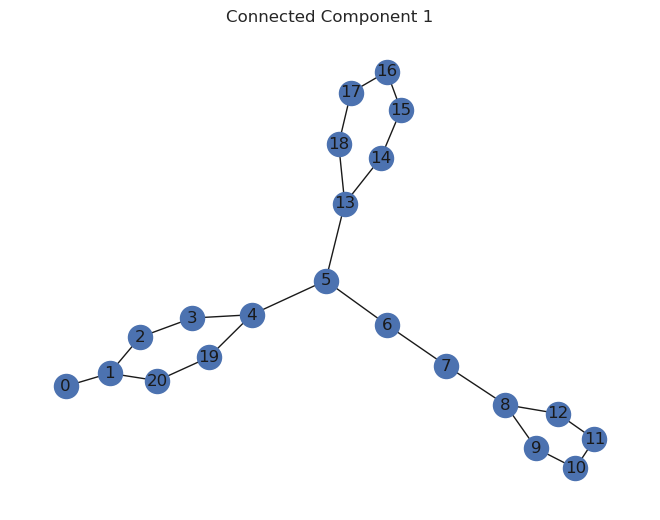

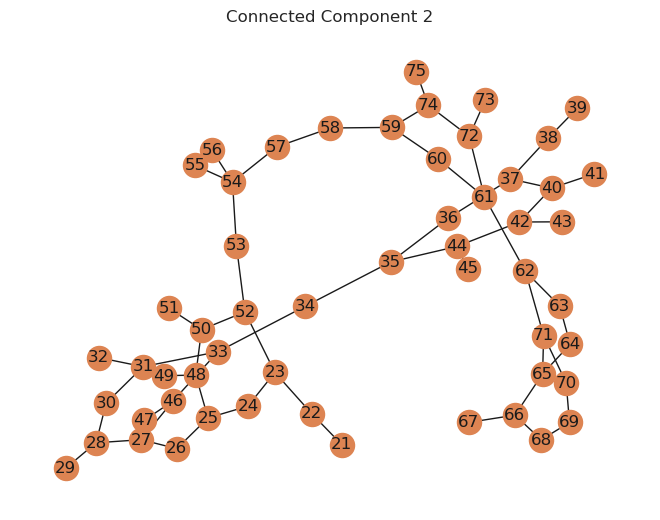

In [38]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

data = torch_geometric.data.Data(edge_index=edge_index)
G = torch_geometric.utils.to_networkx(data, to_undirected=True)
# Get the connected components
connected_components = list(nx.connected_components(G))

# Plot each connected component separately
for i, component in enumerate(connected_components[:2]):
    subgraph = G.subgraph(component)

    # Draw the subgraph
    plt.figure()
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color=f"C{i}", cmap=plt.cm.rainbow)

    plt.title(f"Connected Component {i + 1}")

plt.show()

## Model Pipeline

In [6]:
def model_pipeline(hyperparameters, run_name="run", model_path=None, n_epochs_before=0):
    print(hyperparameters)
    # tell wandb to get started
    run_name = run_name + get_date_time_string()
    print("run_name : ", run_name)
    with wandb.init(project=PROJECT_NAME, config=hyperparameters, name=run_name):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        print("Making dataloaders and loading model")
        model, train_loader, val_loader, criterion, optimizer = make(config)
        if model_path != None:
            model.load_state_dict(torch.load(model_path))  # a .pth file

        # and use them to train the model
        print("Start training")
        if model_path != None:
            n_train_samples = 26408
            example_ct_before = n_epochs_before * n_train_samples
        else:
            example_ct_before = 0
        train(
            model,
            train_loader,
            criterion,
            optimizer,
            config,
            run_name,
            val_loader=val_loader,
            example_ct_before=example_ct_before,
        )
        print("Successful training")

        return model

### Losses and Make

In [7]:
CE = torch.nn.CrossEntropyLoss()


def contrastive_loss(v1, v2):
    logits = torch.matmul(v1, torch.transpose(v2, 0, 1))
    labels = torch.arange(logits.shape[0], device=v1.device)
    return CE(logits, labels) + CE(torch.transpose(logits, 0, 1), labels)


def contrastive_loss_graph_classif(x_graph, x_text):
    logits = torch.matmul(x_graph, torch.transpose(x_text, 0, 1))  # (graph, text)
    labels = torch.arange(logits.shape[0], device=x_graph.device)
    return CE(torch.transpose(logits, 0, 1), labels)


def n_uplet_loss(x_graph, x_text):
    # x_graph and x_text must be normalized
    logits = torch.matmul(x_graph, torch.transpose(x_text, 0, 1))  # (graph, text)
    batch_size = logits.shape[0]
    device = x_graph.device
    labels = 2 * torch.eye(batch_size, device=device) - torch.ones(
        (batch_size, batch_size), device=device
    )
    loss = torch.mean((logits - labels) ** 2)

    return loss


BCEL = nn.BCEWithLogitsLoss()


def negative_sampling_contrastive_loss(v1, v2):
    logits = torch.matmul(v1, torch.transpose(v2, 0, 1))
    labels = torch.diag_embed(torch.ones(logits.shape[0])).to(v1.device)
    return BCEL(logits, labels)


criterion_dico = {
    "contrastive_loss": contrastive_loss,
    "contrastive_loss_graph_classif": contrastive_loss_graph_classif,
    "n_uplet_loss": n_uplet_loss,
    "negative_sampling_contrastive_loss": negative_sampling_contrastive_loss,
}

### Make

In [8]:
# def make(config):
#     # Make the data (train_loader, val_loader)
#     tokenizer = AutoTokenizer.from_pretrained(config.model_name)
#     gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
#     val_dataset = GraphTextDataset(root='./data/', gt=gt, split='val', tokenizer=tokenizer)
#     train_dataset = GraphTextDataset(root='./data/', gt=gt, split='train', tokenizer=tokenizer)
#     val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, num_workers=16)
#     train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=16)

#     # Make the model (model)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("device :", device)
#     model = Model(model_name=config.model_name, num_node_features=300, nout=768, nhid=300, graph_hidden_channels=300) # nout = bert model hidden dim
#     model.to(device)

#     # Make the loss and optimizer (criterion, optimizer)
#     criterion = criterion_dico[config.criterion]
#     optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate,
#                                     betas=(0.9, 0.999),
#                                     weight_decay=0.01)

#     return model, train_loader, val_loader, criterion, optimizer

In [9]:
!nvidia-smi

Wed Jan 31 22:55:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:01:00.0 Off |                  Off |
| 56%   81C    P2             225W / 230W |  11777MiB / 24564MiB |     94%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
def make(config):
    # Make the data (train_loader, val_loader)
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
    val_dataset = GraphTextDataset(
        root="./data/", gt=gt, split="val", tokenizer=tokenizer
    )
    train_dataset = GraphTextDataset(
        root="./data/", gt=gt, split="train", tokenizer=tokenizer
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=True, num_workers=20
    )
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=20
    )

    # Make the model (model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device :", device)
    model = Model(
        model_name=config.model_name,
        num_node_features=300,
        nout=768,
        nhid=300,
        graph_hidden_channels=300,
    )  # nout = bert model hidden dim
    model.to(device)

    # Make the loss and optimizer (criterion, optimizer)
    criterion = criterion_dico[config.criterion]
    model_params_dico = [
        {"params": model.graph_encoder.parameters(), "lr": config.graph_learning_rate},
        {"params": model.text_encoder.parameters(), "lr": config.text_learning_rate},
    ]
    optimizer = optim.AdamW(
        model_params_dico,
        lr=config.learning_rate,
        betas=(0.9, 0.999),
        weight_decay=0.01,
    )

    return model, train_loader, val_loader, criterion, optimizer

# III) Models

# IV) Define Training Logic

Track gradients with `wandb.watch` and everything else with `wandb.log`

`wandb.watch` will log the gradients and the parameters of your model,
every `log_freq` steps of training.

`wandb.log` expects a dictionary with strings as keys.
These strings identify the objects being logged, which make up the values.
You can also optionally log which `step` (example count, batch count, epoch) of training you're on.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_dico = {
    "cosine_similarity": cosine_similarity,
}


def train(
    model,
    train_loader,
    criterion,
    optimizer,
    config,
    run_name,
    val_loader=None,
    example_ct_before=0,
):
    log_every_n_batches = 50  # TODO
    # Tell wandb to watch the model (gradients, weights) over time
    wandb.watch(model, criterion, log="all", log_freq=log_every_n_batches)  # TODO

    # Run training
    model.train()
    example_ct = example_ct_before  # number of examples seen (example count)
    batch_ct = 0  # number of batches seen (batch count)
    for epoch in tqdm(range(config.epochs)):
        # Train on train dataloader
        moving_average_loss = 0
        log_example_ct = 0
        for batch in tqdm(train_loader, leave=False):
            current_loss, batch_example_ct = train_batch(
                batch, model, optimizer, criterion
            )
            example_ct += batch_example_ct
            batch_ct += 1
            moving_average_loss += current_loss
            log_example_ct += batch_example_ct

            # log metrics every 25th batch with wandb
            if ((batch_ct + 1) % log_every_n_batches) == 0:
                moving_average_loss /= log_example_ct
                wandb.log(
                    {"epoch": epoch, "train_current_loss": moving_average_loss},
                    step=example_ct,
                )
                print(
                    f"train_loss after {str(example_ct).zfill(5)} examples: {moving_average_loss:.5f}"
                )
                moving_average_loss = 0
                log_example_ct = 0

        # Evaluation
        similarity_fn = similarity_dico[config.similarity_fn]

        # Evaluate on train dataloader
        train_LRAP = evaluate(
            model=model,
            loader=train_loader,
            criterion=criterion,
            similarity_fn=similarity_fn,
            metric_fn=LRAP_accuracy,
            log_prefix="train",
            example_ct=example_ct,
        )

        # Evaluate on val dataloader
        if val_loader != None:
            val_LRAP = evaluate(
                model=model,
                loader=val_loader,
                criterion=criterion,
                similarity_fn=similarity_fn,
                metric_fn=LRAP_accuracy,
                log_prefix="val",
                example_ct=example_ct,
            )

    # Save the model
    folder_path = "models/" + run_name
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    save_path = folder_path + "/" + run_name + "_" + str(config.epochs) + ".pth"
    torch.save(model.state_dict(), save_path)

    # Save the config
    yaml_file_path = folder_path + "/" + "config.yaml"
    with open(yaml_file_path, "w") as file:
        yaml.dump(wandb.config._as_dict(), file, default_flow_style=False)


def train_batch(batch, model, optimizer, criterion):
    # extract batch
    input_ids = batch.input_ids
    batch_example_ct = batch.input_ids.shape[0]
    batch.pop("input_ids")
    attention_mask = batch.attention_mask
    batch.pop("attention_mask")
    graph_batch = batch

    # compute loss
    x_graph, x_text = model(
        graph_batch.to(device), input_ids.to(device), attention_mask.to(device)
    )
    current_loss = criterion(x_graph, x_text)
    optimizer.zero_grad()
    current_loss.backward()
    optimizer.step()

    return current_loss, batch_example_ct


def evaluate(
    model, loader, criterion, similarity_fn, metric_fn, log_prefix, example_ct
):
    model.eval()
    with torch.no_grad():
        graph_embeddings = []
        text_embeddings = []
        for batch in tqdm(loader, leave=False):
            input_ids = batch.input_ids
            batch.pop("input_ids")
            attention_mask = batch.attention_mask
            batch.pop("attention_mask")
            graph_batch = batch

            # compute loss
            x_graph, x_text = model(
                graph_batch.to(device), input_ids.to(device), attention_mask.to(device)
            )

            for output in x_graph:
                graph_embeddings.append(output.tolist())
            for output in x_text:
                text_embeddings.append(output.tolist())

        # Compute metrics on the whole dataset
        similarity_matrix = similarity_fn(text_embeddings, graph_embeddings)
        LRAP = metric_fn(similarity_matrix)
        epoch_loss = criterion(
            torch.FloatTensor(text_embeddings), torch.FloatTensor(graph_embeddings)
        )

        # log the metrics
        wandb.log(
            {log_prefix + "_LRAP": LRAP, log_prefix + "_loss": epoch_loss},
            step=example_ct,
        )

    return LRAP

# VI) Run experiments

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    learning_rate=2e-5,
    epochs=20,
    criterion="contrastive_loss",
    similarity_fn="cosine_similarity",
)

run_name = "baseline_v2"

model_pipeline(
    config,
    run_name=run_name,
    model_path="models/baseline_01270322/baseline_01270322_9.pth",
    n_epochs_before=10,
)

In [ ]:
config = dict(
    model_name="allenai/scibert_scivocab_uncased",
    batch_size=32,
    learning_rate=2e-5,
    epochs=10,
    criterion="contrastive_loss",
    similarity_fn="cosine_similarity",
)

run_name = "scibert_baseline"

model_pipeline(config, run_name=run_name)

pas si ouf scibert

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=10,
    criterion="contrastive_loss",
    similarity_fn="cosine_similarity",
)

run_name = "baseline_two_LR"

model_pipeline(config, run_name=run_name)

2 learning rate = un peu mieux

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=10,
    criterion="contrastive_loss_graph_classif",
    similarity_fn="cosine_similarity",
    layer_norm=True,
)

run_name = "baseline_contrastive_loss_graph_classif"

model_pipeline(config, run_name=run_name)

moins bien que la version avec les 2 termes

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=10,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=True,
)

run_name = "baseline_negative_sampling_contrastive_loss"

model_pipeline(config, run_name=run_name)

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=32,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=50,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=False,
)

run_name = "baseline_negative_sampling_contrastive_loss_v2"

model_pipeline(
    config,
    run_name=run_name,
    model_path="models/baseline_negative_sampling_contrastive_loss_01281939/baseline_negative_sampling_contrastive_loss_01281939_9.pth",
    n_epochs_before=10,
)

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=64,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=10,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=True,
)

run_name = "baseline_NSCL_64_batch"

model_pipeline(config, run_name=run_name)

In [ ]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=128,
    graph_learning_rate=1e-4,
    text_learning_rate=3e-5,
    learning_rate=1e-4,
    epochs=80,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=False,
)

run_name = "baseline_NSCL_big_graph_model_batch_128"

model_pipeline(config, run_name=run_name)

In [12]:
config = dict(
    model_name="distilbert-base-uncased",
    batch_size=8,
    graph_learning_rate=2e-5,
    text_learning_rate=1e-5,
    learning_rate=1e-4,
    epochs=20,
    criterion="negative_sampling_contrastive_loss",
    similarity_fn="cosine_similarity",
    layer_norm=False,
)

run_name = "baseline_NSCL_big_graph_model_batch_8"

model_pipeline(config, run_name=run_name)

{'model_name': 'distilbert-base-uncased', 'batch_size': 8, 'graph_learning_rate': 2e-05, 'text_learning_rate': 1e-05, 'learning_rate': 0.0001, 'epochs': 20, 'criterion': 'negative_sampling_contrastive_loss', 'similarity_fn': 'cosine_similarity', 'layer_norm': False}
run_name :  baseline_NSCL_big_graph_model_batch_8_01300911


Making dataloaders and loading model


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device : cuda
Start training


  0%|          | 0/20 [00:00<?, ?it/s]/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [318], which does not match the required output shape [2, 318]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 00392 examples: 0.04872


train_loss after 00792 examples: 0.04718


train_loss after 01192 examples: 0.04712


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [306], which does not match the required output shape [2, 306]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 01592 examples: 0.04693


train_loss after 01992 examples: 0.04574


train_loss after 02392 examples: 0.04324


train_loss after 02792 examples: 0.04024


train_loss after 03192 examples: 0.03872


train_loss after 03592 examples: 0.03781


train_loss after 03992 examples: 0.03617


train_loss after 04392 examples: 0.03462


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [290], which does not match the required output shape [2, 290]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 04792 examples: 0.03451


train_loss after 05192 examples: 0.03302


train_loss after 05592 examples: 0.03190


train_loss after 05992 examples: 0.03156


train_loss after 06392 examples: 0.03059


train_loss after 06792 examples: 0.03054


train_loss after 07192 examples: 0.02917


train_loss after 07592 examples: 0.02951


train_loss after 07992 examples: 0.02836


train_loss after 08392 examples: 0.02694


train_loss after 08792 examples: 0.02720


train_loss after 09192 examples: 0.02704


train_loss after 09592 examples: 0.02461


train_loss after 09992 examples: 0.02484


train_loss after 10392 examples: 0.02637


train_loss after 10792 examples: 0.02509


train_loss after 11192 examples: 0.02323


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [546], which does not match the required output shape [2, 546]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 11592 examples: 0.02448


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [436], which does not match the required output shape [2, 436]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 11992 examples: 0.02345


train_loss after 12392 examples: 0.02270


train_loss after 12792 examples: 0.02438


train_loss after 13192 examples: 0.02258


train_loss after 13592 examples: 0.02103


train_loss after 13992 examples: 0.02152


train_loss after 14392 examples: 0.02217


train_loss after 14792 examples: 0.02051


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [524], which does not match the required output shape [2, 524]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 15192 examples: 0.01995


train_loss after 15592 examples: 0.02200


train_loss after 15992 examples: 0.02213


train_loss after 16392 examples: 0.01962


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [402], which does not match the required output shape [2, 402]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 16792 examples: 0.01971


train_loss after 17192 examples: 0.02009


train_loss after 17592 examples: 0.02134


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [586], which does not match the required output shape [2, 586]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 17992 examples: 0.02267


train_loss after 18392 examples: 0.01942


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [424], which does not match the required output shape [2, 424]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 18792 examples: 0.01982


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [494], which does not match the required output shape [2, 494]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 19192 examples: 0.01919


train_loss after 19592 examples: 0.01825


train_loss after 19992 examples: 0.01787


train_loss after 20392 examples: 0.01989


train_loss after 20792 examples: 0.01932


train_loss after 21192 examples: 0.01882


train_loss after 21592 examples: 0.01995


train_loss after 21992 examples: 0.01926


train_loss after 22392 examples: 0.01896


train_loss after 22792 examples: 0.01731


train_loss after 23192 examples: 0.01839


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [358], which does not match the required output shape [2, 358]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 23592 examples: 0.01730


train_loss after 23992 examples: 0.01994


train_loss after 24392 examples: 0.01741


train_loss after 24792 examples: 0.01705


train_loss after 25192 examples: 0.01878


train_loss after 25592 examples: 0.01754


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [456], which does not match the required output shape [2, 456]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 25992 examples: 0.01880


train_loss after 26392 examples: 0.01766


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [424], which does not match the required output shape [2, 424]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [322], which does not match the required output shape [2, 322]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 26792 examples: 0.01506


train_loss after 27192 examples: 0.01675


train_loss after 27592 examples: 0.01505


train_loss after 27992 examples: 0.01443


train_loss after 28392 examples: 0.01514


train_loss after 28792 examples: 0.01522


train_loss after 29192 examples: 0.01757


train_loss after 29592 examples: 0.01432


train_loss after 29992 examples: 0.01570


train_loss after 30392 examples: 0.01600


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [518], which does not match the required output shape [2, 518]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 30792 examples: 0.01668


train_loss after 31192 examples: 0.01622


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1238], which does not match the required output shape [2, 1238]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 31592 examples: 0.01605


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [524], which does not match the required output shape [2, 524]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 31992 examples: 0.01621


train_loss after 32392 examples: 0.01458


train_loss after 32792 examples: 0.01468


train_loss after 33192 examples: 0.01614


train_loss after 33592 examples: 0.01491


train_loss after 33992 examples: 0.01732


train_loss after 34392 examples: 0.01578


train_loss after 34792 examples: 0.01610


train_loss after 35192 examples: 0.01529


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [470], which does not match the required output shape [2, 470]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 35592 examples: 0.01372


train_loss after 35992 examples: 0.01307


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [520], which does not match the required output shape [2, 520]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 36392 examples: 0.01476


train_loss after 36792 examples: 0.01245


train_loss after 37192 examples: 0.01423


train_loss after 37592 examples: 0.01389


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [528], which does not match the required output shape [2, 528]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 37992 examples: 0.01373


train_loss after 38392 examples: 0.01416


train_loss after 38792 examples: 0.01411


train_loss after 39192 examples: 0.01494


train_loss after 39592 examples: 0.01266


train_loss after 39992 examples: 0.01473


train_loss after 40392 examples: 0.01302


train_loss after 40792 examples: 0.01380


train_loss after 41192 examples: 0.01371


train_loss after 41592 examples: 0.01240


train_loss after 41992 examples: 0.01330


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [478], which does not match the required output shape [2, 478]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 42392 examples: 0.01165


train_loss after 42792 examples: 0.01448


train_loss after 43192 examples: 0.01280


train_loss after 43592 examples: 0.01304


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [338], which does not match the required output shape [2, 338]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [760], which does not match the required output shape [2, 760]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 43992 examples: 0.01316


train_loss after 44392 examples: 0.01210


train_loss after 44792 examples: 0.01325


train_loss after 45192 examples: 0.01272


train_loss after 45592 examples: 0.01345


train_loss after 45992 examples: 0.01215


train_loss after 46392 examples: 0.01236


train_loss after 46792 examples: 0.01224


train_loss after 47192 examples: 0.01241


train_loss after 47592 examples: 0.01159


train_loss after 47992 examples: 0.01428


train_loss after 48392 examples: 0.01340


train_loss after 48792 examples: 0.01279


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [552], which does not match the required output shape [2, 552]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 49192 examples: 0.01263


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [374], which does not match the required output shape [2, 374]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 49592 examples: 0.01262


train_loss after 49992 examples: 0.01214


train_loss after 50392 examples: 0.01287


train_loss after 50792 examples: 0.01132


train_loss after 51192 examples: 0.01239


train_loss after 51592 examples: 0.01286


train_loss after 51992 examples: 0.01112


train_loss after 52392 examples: 0.01202


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [438], which does not match the required output shape [2, 438]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 52792 examples: 0.01348


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [378], which does not match the required output shape [2, 378]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)

/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [460], which does not match the required output shape [2, 460]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t 

train_loss after 53192 examples: 0.01137


train_loss after 53592 examples: 0.01157


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [562], which does not match the required output shape [2, 562]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 53992 examples: 0.01077


train_loss after 54392 examples: 0.01014


train_loss after 54792 examples: 0.01106


train_loss after 55192 examples: 0.01073


train_loss after 55592 examples: 0.01132


train_loss after 55992 examples: 0.01074


train_loss after 56392 examples: 0.01057


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [400], which does not match the required output shape [2, 400]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 56792 examples: 0.00989


train_loss after 57192 examples: 0.01153


train_loss after 57592 examples: 0.01313


train_loss after 57992 examples: 0.01104


train_loss after 58392 examples: 0.01084


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [536], which does not match the required output shape [2, 536]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 58792 examples: 0.00951


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [368], which does not match the required output shape [2, 368]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 59192 examples: 0.01045


train_loss after 59592 examples: 0.00993


train_loss after 59992 examples: 0.01059


train_loss after 60392 examples: 0.00995


train_loss after 60792 examples: 0.00973


train_loss after 61192 examples: 0.01038


train_loss after 61592 examples: 0.00835


train_loss after 61992 examples: 0.01019


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [470], which does not match the required output shape [2, 470]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 62392 examples: 0.01183


train_loss after 62792 examples: 0.01088


train_loss after 63192 examples: 0.00976


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [716], which does not match the required output shape [2, 716]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 63592 examples: 0.01058


train_loss after 63992 examples: 0.00975


train_loss after 64392 examples: 0.01065


train_loss after 64792 examples: 0.00953


train_loss after 65192 examples: 0.00989


train_loss after 65592 examples: 0.00944


train_loss after 65992 examples: 0.01071


train_loss after 66392 examples: 0.01036


train_loss after 66792 examples: 0.00963


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1102], which does not match the required output shape [2, 1102]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 67192 examples: 0.01044


train_loss after 67592 examples: 0.01043


train_loss after 67992 examples: 0.00930


train_loss after 68392 examples: 0.00955


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [276], which does not match the required output shape [2, 276]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 68792 examples: 0.00905


train_loss after 69192 examples: 0.01053


train_loss after 69592 examples: 0.00939


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [404], which does not match the required output shape [2, 404]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 69992 examples: 0.00963


train_loss after 70392 examples: 0.01111


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [234], which does not match the required output shape [2, 234]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 70792 examples: 0.00947


train_loss after 71192 examples: 0.00958


train_loss after 71592 examples: 0.00873


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [184], which does not match the required output shape [2, 184]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 71992 examples: 0.00993


train_loss after 72392 examples: 0.01059


train_loss after 72792 examples: 0.01104


train_loss after 73192 examples: 0.01144


train_loss after 73592 examples: 0.00931


train_loss after 73992 examples: 0.00873


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [582], which does not match the required output shape [2, 582]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 74392 examples: 0.00917


train_loss after 74792 examples: 0.00957


train_loss after 75192 examples: 0.00861


train_loss after 75592 examples: 0.01041


train_loss after 75992 examples: 0.01086


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [390], which does not match the required output shape [2, 390]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 76392 examples: 0.00866


train_loss after 76792 examples: 0.01032


train_loss after 77192 examples: 0.00948


train_loss after 77592 examples: 0.00888


train_loss after 77992 examples: 0.01072


train_loss after 78392 examples: 0.00945


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [1138], which does not match the required output shape [2, 1138]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 78792 examples: 0.00916


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [540], which does not match the required output shape [2, 540]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 79192 examples: 0.00862


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [588], which does not match the required output shape [2, 588]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [446], which does not match the required output shape [2, 446]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 79592 examples: 0.00861


train_loss after 79992 examples: 0.00817


train_loss after 80392 examples: 0.00892


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [304], which does not match the required output shape [2, 304]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 80792 examples: 0.00783


train_loss after 81192 examples: 0.00867


train_loss after 81592 examples: 0.00851


train_loss after 81992 examples: 0.00837


train_loss after 82392 examples: 0.00737


train_loss after 82792 examples: 0.00936


train_loss after 83192 examples: 0.00855


train_loss after 83592 examples: 0.00811


train_loss after 83992 examples: 0.00760


train_loss after 84392 examples: 0.00859


train_loss after 84792 examples: 0.00828


train_loss after 85192 examples: 0.00882


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [680], which does not match the required output shape [2, 680]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 85592 examples: 0.00747


train_loss after 85992 examples: 0.00685


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [416], which does not match the required output shape [2, 416]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 86392 examples: 0.00910


train_loss after 86792 examples: 0.00877


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [2, 320]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 87192 examples: 0.00709


train_loss after 87592 examples: 0.00890


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [686], which does not match the required output shape [2, 686]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 87992 examples: 0.00994


train_loss after 88392 examples: 0.00812


train_loss after 88792 examples: 0.00645


train_loss after 89192 examples: 0.00776


train_loss after 89592 examples: 0.00661


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [344], which does not match the required output shape [2, 344]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 89992 examples: 0.00717


train_loss after 90392 examples: 0.00860


train_loss after 90792 examples: 0.00854


train_loss after 91192 examples: 0.00743


train_loss after 91592 examples: 0.00900


train_loss after 91992 examples: 0.00895


train_loss after 92392 examples: 0.00870


train_loss after 92792 examples: 0.00825


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [422], which does not match the required output shape [2, 422]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 93192 examples: 0.00694


train_loss after 93592 examples: 0.00761


train_loss after 93992 examples: 0.00880


train_loss after 94392 examples: 0.00890


train_loss after 94792 examples: 0.00773


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [662], which does not match the required output shape [2, 662]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 95192 examples: 0.00736


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [706], which does not match the required output shape [2, 706]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 95592 examples: 0.00793


train_loss after 95992 examples: 0.00777


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [564], which does not match the required output shape [2, 564]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 96392 examples: 0.00790


train_loss after 96792 examples: 0.00781


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [488], which does not match the required output shape [2, 488]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 97192 examples: 0.00685


train_loss after 97592 examples: 0.00923


train_loss after 97992 examples: 0.00882


train_loss after 98392 examples: 0.00826


train_loss after 98792 examples: 0.00843


train_loss after 99192 examples: 0.00857


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [282], which does not match the required output shape [2, 282]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 99592 examples: 0.00857


train_loss after 99992 examples: 0.00972


train_loss after 100392 examples: 0.00864


train_loss after 100792 examples: 0.00683


train_loss after 101192 examples: 0.00647


train_loss after 101592 examples: 0.00807


train_loss after 101992 examples: 0.00724


train_loss after 102392 examples: 0.00835


train_loss after 102792 examples: 0.00824


train_loss after 103192 examples: 0.00613


train_loss after 103592 examples: 0.00653


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [364], which does not match the required output shape [2, 364]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 103992 examples: 0.00803


train_loss after 104392 examples: 0.00889


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [478], which does not match the required output shape [2, 478]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 104792 examples: 0.00850


train_loss after 105192 examples: 0.00649


train_loss after 105592 examples: 0.00783


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [330], which does not match the required output shape [2, 330]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [286], which does not match the required output shape [2, 286]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 105992 examples: 0.00797


train_loss after 106392 examples: 0.00542


train_loss after 106792 examples: 0.00751


train_loss after 107192 examples: 0.00829


train_loss after 107592 examples: 0.00556


train_loss after 107992 examples: 0.00579


train_loss after 108392 examples: 0.00739


train_loss after 108792 examples: 0.00745


train_loss after 109192 examples: 0.00698


train_loss after 109592 examples: 0.00645


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [534], which does not match the required output shape [2, 534]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 109992 examples: 0.00724


train_loss after 110392 examples: 0.00644


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [368], which does not match the required output shape [2, 368]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 110792 examples: 0.00834


train_loss after 111192 examples: 0.00662


train_loss after 111592 examples: 0.00724


train_loss after 111992 examples: 0.00742


train_loss after 112392 examples: 0.00714


train_loss after 112792 examples: 0.00703


train_loss after 113192 examples: 0.00714


train_loss after 113592 examples: 0.00761


train_loss after 113992 examples: 0.00823


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [360], which does not match the required output shape [2, 360]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 114392 examples: 0.00722


train_loss after 114792 examples: 0.00688


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [402], which does not match the required output shape [2, 402]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 115192 examples: 0.00725


train_loss after 115592 examples: 0.00641


train_loss after 115992 examples: 0.00784


train_loss after 116392 examples: 0.00691


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [368], which does not match the required output shape [2, 368]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 116792 examples: 0.00696


train_loss after 117192 examples: 0.00653


train_loss after 117592 examples: 0.00596


train_loss after 117992 examples: 0.00778


train_loss after 118392 examples: 0.00803


train_loss after 118792 examples: 0.00706


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [404], which does not match the required output shape [2, 404]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 119192 examples: 0.00557


train_loss after 119592 examples: 0.00638


train_loss after 119992 examples: 0.00597


train_loss after 120392 examples: 0.00683


train_loss after 120792 examples: 0.00795


train_loss after 121192 examples: 0.00761


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [512], which does not match the required output shape [2, 512]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 121592 examples: 0.00688


train_loss after 121992 examples: 0.00690


train_loss after 122392 examples: 0.00788


train_loss after 122792 examples: 0.00721


train_loss after 123192 examples: 0.00582


train_loss after 123592 examples: 0.00629


train_loss after 123992 examples: 0.00685


train_loss after 124392 examples: 0.00546


train_loss after 124792 examples: 0.00545


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [240], which does not match the required output shape [2, 240]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 125192 examples: 0.00676


train_loss after 125592 examples: 0.00752


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [288], which does not match the required output shape [2, 288]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 125992 examples: 0.00687


train_loss after 126392 examples: 0.00677


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [442], which does not match the required output shape [2, 442]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [388], which does not match the required output shape [2, 388]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 126792 examples: 0.00644


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [514], which does not match the required output shape [2, 514]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 127192 examples: 0.00689


train_loss after 127592 examples: 0.00609


train_loss after 127992 examples: 0.00655


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [606], which does not match the required output shape [2, 606]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 128392 examples: 0.00698


train_loss after 128792 examples: 0.00749


train_loss after 129192 examples: 0.00645


train_loss after 129592 examples: 0.00597


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [308], which does not match the required output shape [2, 308]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 129992 examples: 0.00745


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [514], which does not match the required output shape [2, 514]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 130392 examples: 0.00645


train_loss after 130792 examples: 0.00980


train_loss after 131192 examples: 0.00777


train_loss after 131592 examples: 0.00645


train_loss after 131992 examples: 0.00724


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [398], which does not match the required output shape [2, 398]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [466], which does not match the required output shape [2, 466]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 132392 examples: 0.00577


train_loss after 132792 examples: 0.00454


train_loss after 133192 examples: 0.00692


train_loss after 133592 examples: 0.00554


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [690], which does not match the required output shape [2, 690]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 133992 examples: 0.00526


train_loss after 134392 examples: 0.00633


train_loss after 134792 examples: 0.00684


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [986], which does not match the required output shape [2, 986]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 135192 examples: 0.00709


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [520], which does not match the required output shape [2, 520]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 135592 examples: 0.00441


train_loss after 135992 examples: 0.00608


train_loss after 136392 examples: 0.00477


train_loss after 136792 examples: 0.00506


train_loss after 137192 examples: 0.00631


train_loss after 137592 examples: 0.00655


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [284], which does not match the required output shape [2, 284]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 137992 examples: 0.00642


train_loss after 138392 examples: 0.00616


train_loss after 138792 examples: 0.00615


train_loss after 139192 examples: 0.00527


train_loss after 139592 examples: 0.00529


train_loss after 139992 examples: 0.00705


train_loss after 140392 examples: 0.00605


train_loss after 140792 examples: 0.00621


train_loss after 141192 examples: 0.00642


train_loss after 141592 examples: 0.00632


train_loss after 141992 examples: 0.00584


train_loss after 142392 examples: 0.00548


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [482], which does not match the required output shape [2, 482]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 142792 examples: 0.00603


train_loss after 143192 examples: 0.00639


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [480], which does not match the required output shape [2, 480]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 143592 examples: 0.00552


train_loss after 143992 examples: 0.00499


train_loss after 144392 examples: 0.00716


train_loss after 144792 examples: 0.00526


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [304], which does not match the required output shape [2, 304]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 145192 examples: 0.00613


train_loss after 145592 examples: 0.00561


train_loss after 145992 examples: 0.00578


train_loss after 146392 examples: 0.00644


train_loss after 146792 examples: 0.00582


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [430], which does not match the required output shape [2, 430]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 147192 examples: 0.00621


train_loss after 147592 examples: 0.00498


train_loss after 147992 examples: 0.00551


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [458], which does not match the required output shape [2, 458]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 148392 examples: 0.00534


train_loss after 148792 examples: 0.00544


train_loss after 149192 examples: 0.00543


train_loss after 149592 examples: 0.00546


train_loss after 149992 examples: 0.00701


train_loss after 150392 examples: 0.00645


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [518], which does not match the required output shape [2, 518]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 150792 examples: 0.00519


train_loss after 151192 examples: 0.00553


train_loss after 151592 examples: 0.00555


train_loss after 151992 examples: 0.00530


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [446], which does not match the required output shape [2, 446]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 152392 examples: 0.00652


train_loss after 152792 examples: 0.00578


train_loss after 153192 examples: 0.00465


train_loss after 153592 examples: 0.00618


train_loss after 153992 examples: 0.00792


train_loss after 154392 examples: 0.00643


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [612], which does not match the required output shape [2, 612]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 154792 examples: 0.00666


train_loss after 155192 examples: 0.00591


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [224], which does not match the required output shape [2, 224]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 155592 examples: 0.00581


train_loss after 155992 examples: 0.00549


train_loss after 156392 examples: 0.00622


train_loss after 156792 examples: 0.00506


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [850], which does not match the required output shape [2, 850]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 157192 examples: 0.00677


train_loss after 157592 examples: 0.00576


train_loss after 157992 examples: 0.00665


train_loss after 158392 examples: 0.00628


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [662], which does not match the required output shape [2, 662]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [598], which does not match the required output shape [2, 598]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 158792 examples: 0.00637


train_loss after 159192 examples: 0.00554


train_loss after 159592 examples: 0.00524


train_loss after 159992 examples: 0.00617


train_loss after 160392 examples: 0.00656


train_loss after 160792 examples: 0.00648


train_loss after 161192 examples: 0.00440


train_loss after 161592 examples: 0.00548


train_loss after 161992 examples: 0.00470


train_loss after 162392 examples: 0.00590


train_loss after 162792 examples: 0.00583


train_loss after 163192 examples: 0.00547


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [442], which does not match the required output shape [2, 442]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 163592 examples: 0.00466


train_loss after 163992 examples: 0.00509


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [334], which does not match the required output shape [2, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 164392 examples: 0.00573


train_loss after 164792 examples: 0.00484


train_loss after 165192 examples: 0.00507


train_loss after 165592 examples: 0.00522


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [594], which does not match the required output shape [2, 594]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 165992 examples: 0.00622


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [450], which does not match the required output shape [2, 450]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 166392 examples: 0.00564


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [624], which does not match the required output shape [2, 624]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 166792 examples: 0.00464


train_loss after 167192 examples: 0.00504


train_loss after 167592 examples: 0.00524


train_loss after 167992 examples: 0.00550


train_loss after 168392 examples: 0.00511


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [892], which does not match the required output shape [2, 892]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 168792 examples: 0.00445


train_loss after 169192 examples: 0.00562


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [798], which does not match the required output shape [2, 798]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 169592 examples: 0.00474


train_loss after 169992 examples: 0.00707


train_loss after 170392 examples: 0.00619


train_loss after 170792 examples: 0.00434


train_loss after 171192 examples: 0.00529


train_loss after 171592 examples: 0.00472


train_loss after 171992 examples: 0.00637


train_loss after 172392 examples: 0.00475


train_loss after 172792 examples: 0.00508


train_loss after 173192 examples: 0.00430


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [388], which does not match the required output shape [2, 388]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 173592 examples: 0.00524


train_loss after 173992 examples: 0.00497


train_loss after 174392 examples: 0.00380


train_loss after 174792 examples: 0.00499


train_loss after 175192 examples: 0.00546


train_loss after 175592 examples: 0.00623


train_loss after 175992 examples: 0.00619


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [660], which does not match the required output shape [2, 660]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 176392 examples: 0.00560


train_loss after 176792 examples: 0.00499


train_loss after 177192 examples: 0.00541


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [432], which does not match the required output shape [2, 432]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 177592 examples: 0.00437


train_loss after 177992 examples: 0.00691


train_loss after 178392 examples: 0.00609


train_loss after 178792 examples: 0.00406


train_loss after 179192 examples: 0.00511


train_loss after 179592 examples: 0.00601


train_loss after 179992 examples: 0.00508


 82%|████████▏ | 2695/3301 [05:20<00:56, 10.66it/s]

train_loss after 180392 examples: 0.00654


train_loss after 180792 examples: 0.00533


train_loss after 181192 examples: 0.00480


train_loss after 181592 examples: 0.00531


train_loss after 181992 examples: 0.00571


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [334], which does not match the required output shape [2, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 182392 examples: 0.00758


train_loss after 182792 examples: 0.00535


train_loss after 183192 examples: 0.00423


train_loss after 183592 examples: 0.00567


train_loss after 183992 examples: 0.00728


train_loss after 184392 examples: 0.00561


train_loss after 184792 examples: 0.00484


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [352], which does not match the required output shape [2, 352]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [564], which does not match the required output shape [2, 564]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 185192 examples: 0.00444


train_loss after 185592 examples: 0.00502


train_loss after 185992 examples: 0.00447


train_loss after 186392 examples: 0.00469


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [340], which does not match the required output shape [2, 340]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [702], which does not match the required output shape [2, 702]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 186792 examples: 0.00461


train_loss after 187192 examples: 0.00724


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [460], which does not match the required output shape [2, 460]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 187592 examples: 0.00475


train_loss after 187992 examples: 0.00431


train_loss after 188392 examples: 0.00422


train_loss after 188792 examples: 0.00598


train_loss after 189192 examples: 0.00521


train_loss after 189592 examples: 0.00558


train_loss after 189992 examples: 0.00695


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [436], which does not match the required output shape [2, 436]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 190392 examples: 0.00577


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [2, 320]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 190792 examples: 0.00596


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [290], which does not match the required output shape [2, 290]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 191192 examples: 0.00567


train_loss after 191592 examples: 0.00567


train_loss after 191992 examples: 0.00483


train_loss after 192392 examples: 0.00516


train_loss after 192792 examples: 0.00510


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [470], which does not match the required output shape [2, 470]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 193192 examples: 0.00586


train_loss after 193592 examples: 0.00652


train_loss after 193992 examples: 0.00564


train_loss after 194392 examples: 0.00582


train_loss after 194792 examples: 0.00526


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [214], which does not match the required output shape [2, 214]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [448], which does not match the required output shape [2, 448]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 195192 examples: 0.00656


train_loss after 195592 examples: 0.00470


train_loss after 195992 examples: 0.00394


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [520], which does not match the required output shape [2, 520]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 196392 examples: 0.00577


train_loss after 196792 examples: 0.00445


train_loss after 197192 examples: 0.00478


train_loss after 197592 examples: 0.00402


train_loss after 197992 examples: 0.00396


train_loss after 198392 examples: 0.00390


train_loss after 198792 examples: 0.00486


train_loss after 199192 examples: 0.00650


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [432], which does not match the required output shape [2, 432]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 199592 examples: 0.00612


train_loss after 199992 examples: 0.00379


train_loss after 200392 examples: 0.00510


train_loss after 200792 examples: 0.00414


train_loss after 201192 examples: 0.00557


train_loss after 201592 examples: 0.00538


train_loss after 201992 examples: 0.00462


train_loss after 202392 examples: 0.00582


train_loss after 202792 examples: 0.00547


train_loss after 203192 examples: 0.00412


train_loss after 203592 examples: 0.00512


train_loss after 203992 examples: 0.00552


train_loss after 204392 examples: 0.00521


train_loss after 204792 examples: 0.00452


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [270], which does not match the required output shape [2, 270]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [514], which does not match the required output shape [2, 514]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 205192 examples: 0.00509


train_loss after 205592 examples: 0.00682


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [394], which does not match the required output shape [2, 394]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 205992 examples: 0.00470


train_loss after 206392 examples: 0.00391


train_loss after 206792 examples: 0.00510


train_loss after 207192 examples: 0.00480


train_loss after 207592 examples: 0.00494


train_loss after 207992 examples: 0.00384


train_loss after 208392 examples: 0.00441


train_loss after 208792 examples: 0.00548


train_loss after 209192 examples: 0.00529


train_loss after 209592 examples: 0.00440


train_loss after 209992 examples: 0.00568


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [430], which does not match the required output shape [2, 430]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 210392 examples: 0.00499


train_loss after 210792 examples: 0.00484


train_loss after 211192 examples: 0.00535


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [542], which does not match the required output shape [2, 542]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [398], which does not match the required output shape [2, 398]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 211592 examples: 0.00391


train_loss after 211992 examples: 0.00372


train_loss after 212392 examples: 0.00675


train_loss after 212792 examples: 0.00413


train_loss after 213192 examples: 0.00610


train_loss after 213592 examples: 0.00356


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [396], which does not match the required output shape [2, 396]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 213992 examples: 0.00529


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [400], which does not match the required output shape [2, 400]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 214392 examples: 0.00414


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [308], which does not match the required output shape [2, 308]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 214792 examples: 0.00529


train_loss after 215192 examples: 0.00584


train_loss after 215592 examples: 0.00582


train_loss after 215992 examples: 0.00298


train_loss after 216392 examples: 0.00380


train_loss after 216792 examples: 0.00454


train_loss after 217192 examples: 0.00407


train_loss after 217592 examples: 0.00464


train_loss after 217992 examples: 0.00401


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [414], which does not match the required output shape [2, 414]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 218392 examples: 0.00534


train_loss after 218792 examples: 0.00494


train_loss after 219192 examples: 0.00526


train_loss after 219592 examples: 0.00410


train_loss after 219992 examples: 0.00409


train_loss after 220392 examples: 0.00444


train_loss after 220792 examples: 0.00428


train_loss after 221192 examples: 0.00487


train_loss after 221592 examples: 0.00351


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [442], which does not match the required output shape [2, 442]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 221992 examples: 0.00483


train_loss after 222392 examples: 0.00395


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [416], which does not match the required output shape [2, 416]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 222792 examples: 0.00430


train_loss after 223192 examples: 0.00297


train_loss after 223592 examples: 0.00421


train_loss after 223992 examples: 0.00517


train_loss after 224392 examples: 0.00429


train_loss after 224792 examples: 0.00394


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [534], which does not match the required output shape [2, 534]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [546], which does not match the required output shape [2, 546]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 225192 examples: 0.00437


train_loss after 225592 examples: 0.00456


train_loss after 225992 examples: 0.00418


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [762], which does not match the required output shape [2, 762]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 226392 examples: 0.00355


train_loss after 226792 examples: 0.00474


train_loss after 227192 examples: 0.00457


train_loss after 227592 examples: 0.00472


train_loss after 227992 examples: 0.00427


train_loss after 228392 examples: 0.00446


train_loss after 228792 examples: 0.00522


train_loss after 229192 examples: 0.00399


train_loss after 229592 examples: 0.00612


train_loss after 229992 examples: 0.00496


train_loss after 230392 examples: 0.00422


train_loss after 230792 examples: 0.00438


train_loss after 231192 examples: 0.00433


train_loss after 231592 examples: 0.00416


train_loss after 231992 examples: 0.00421


train_loss after 232392 examples: 0.00469


train_loss after 232792 examples: 0.00515


train_loss after 233192 examples: 0.00432


train_loss after 233592 examples: 0.00541


train_loss after 233992 examples: 0.00486


train_loss after 234392 examples: 0.00399


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [324], which does not match the required output shape [2, 324]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 234792 examples: 0.00448


train_loss after 235192 examples: 0.00523


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [550], which does not match the required output shape [2, 550]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 235592 examples: 0.00486


train_loss after 235992 examples: 0.00428


train_loss after 236392 examples: 0.00417


train_loss after 236792 examples: 0.00514


train_loss after 237192 examples: 0.00422


train_loss after 237592 examples: 0.00435


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [464], which does not match the required output shape [2, 464]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [488], which does not match the required output shape [2, 488]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t b

train_loss after 237992 examples: 0.00263


train_loss after 238392 examples: 0.00313


train_loss after 238792 examples: 0.00419


train_loss after 239192 examples: 0.00283


train_loss after 239592 examples: 0.00364


train_loss after 239992 examples: 0.00358


train_loss after 240392 examples: 0.00414


train_loss after 240792 examples: 0.00322


train_loss after 241192 examples: 0.00406


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [280], which does not match the required output shape [2, 280]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 241592 examples: 0.00514


train_loss after 241992 examples: 0.00451


train_loss after 242392 examples: 0.00520


train_loss after 242792 examples: 0.00458


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/data/collate.py:177: UserWarning: An output with one or more elements was resized since it had shape [332], which does not match the required output shape [2, 332]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


train_loss after 243192 examples: 0.00490


train_loss after 243592 examples: 0.00445


train_loss after 243992 examples: 0.00405


# Submission

In [12]:
from sklearn.metrics.pairwise import cosine_similarity  # TODO


# Default config as class instance
class Config_Class:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            setattr(self, k, v)


def get_submission(model_path):
    # Load model
    yaml_path = os.path.dirname(model_path) + "/config.yaml"
    config_dico = load_yaml_config_as_dict(yaml_path)
    config = Config_Class(config_dico)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device :", device)
    model = Model(
        model_name=config.model_name,
        num_node_features=300,
        nout=768,
        nhid=300,
        graph_hidden_channels=300,
    )
    model.load_state_dict(torch.load(model_path))  # a .pth file
    print("Loaded the model")
    model.to(device)
    model.eval()

    batch_size = 64
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    similarity_fn = similarity_dico[config.similarity_fn]

    # Compute the predictions
    graph_model = model.get_graph_encoder()
    text_model = model.get_text_encoder()
    gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
    test_cids_dataset = GraphDataset(root="./data/", gt=gt, split="test_cids")
    test_text_dataset = TextDataset(
        file_path="./data/test_text.txt", tokenizer=tokenizer
    )
    idx_to_cid = test_cids_dataset.get_idx_to_cid()
    test_loader = DataLoader(test_cids_dataset, batch_size=batch_size, shuffle=False)

    graph_embeddings = []
    for batch in tqdm(test_loader):
        for output in graph_model(batch.to(device)):
            graph_embeddings.append(output.tolist())

    test_text_loader = TorchDataLoader(
        test_text_dataset, batch_size=batch_size, shuffle=False
    )
    text_embeddings = []
    for batch in tqdm(test_text_loader):
        for output in text_model(
            batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
        ):
            text_embeddings.append(output.tolist())

    similarity = similarity_fn(text_embeddings, graph_embeddings)
    solution = pd.DataFrame(similarity)
    solution["ID"] = solution.index
    solution = solution[["ID"] + [col for col in solution.columns if col != "ID"]]

    # Saving the predictions in a csv file
    folder_name = "submissions/"
    file_name = os.path.basename(model_path)[:-4]  # get file name and remove ".pth"
    file_name += "_submission.csv"
    submission_path = folder_name + file_name
    solution.to_csv(submission_path, index=False)
    print("Successfully saved submission in : ", submission_path)

    return solution

In [13]:
model_path = (
    "models/baseline_finetunefinetune_01312006/baseline_finetunefinetune_01312006_3.pth"
)
solution = get_submission(model_path)

device : cuda
Loaded the model


/users/eleves-b/2020/thomas.li/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 52/52 [00:17<00:00,  2.91it/s]


Successfully saved submission in :  submissions/baseline_finetunefinetune_01312006_3_submission.csv
